In [ ]:
!pip install keras-tuner

In [18]:
import os,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D

from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform

from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from kerastuner.tuners import BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import pickle

In [19]:
%load_ext autotime
RANDOM_STATE = 42

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [22]:
seed = 7
np.random.seed(seed)

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
tf.test.is_gpu_available()

In [ ]:
tf.test.is_built_with_cuda()

In [23]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder+'/'+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off');
    #print(f"Image shape {img.shape}")
    return img

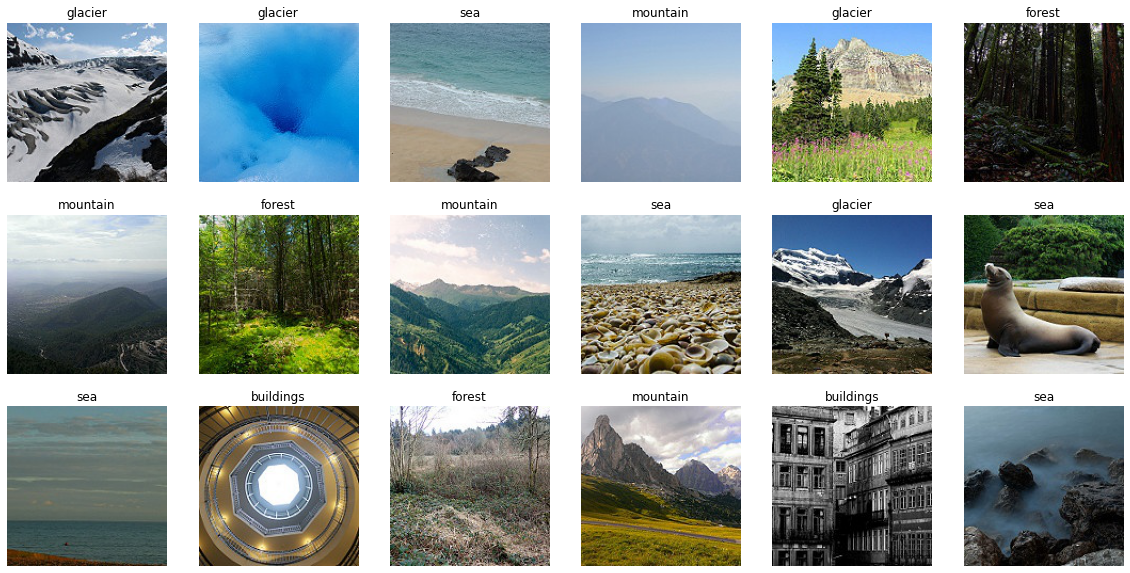

In [24]:
import random
import matplotlib.image as mpimg
from pathlib import Path
import os.path
class_names=['buildings', 'forest', 'glacier', 'mountain' ,'sea' ,'street']
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    class_name = random.choice(class_names)
    img = view_random_image(target_dir='/home/abir/Downloads/greedyhpo/intel/archive/seg_train/seg_train/',target_class=class_name)

In [25]:
train_dir = "/home/abir/Downloads/greedyhpo/intel/archive/seg_train/seg_train"
test_dir = "/home/abir/Downloads/greedyhpo/intel/archive/seg_test/seg_test"
val_dir ="/home/abir/Downloads/greedyhpo/intel/archive/seg_val/seg_test/"

In [26]:
from keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale = 1./255)

training_data = train_data.flow_from_directory(train_dir,
                                              batch_size = 32,
                                              target_size = (32,32), 
                                              class_mode = 'categorical')

val_data = ImageDataGenerator(rescale = 1./255)

validation_data = val_data.flow_from_directory(val_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')


test_data = ImageDataGenerator(rescale = 1./255)

testing_data = test_data.flow_from_directory(test_dir,
                                            batch_size = 32,
                                            target_size = (32,32), 
                                            class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
Found 600 images belonging to 6 classes.


In [27]:
LOG_DIR = f"{int(time.time())}"

In [28]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [29]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [30]:
def build_model(hp):
    input_shape=(32, 32, 3)
    X_input = Input(input_shape)

    X = ZeroPadding2D((1, 1))(X_input)

    X = Conv2D(hp.Choice('s1_filter_size_1', values=[16,32,64,128,256,512],default=16), (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=2, block='a', s=1)
    X = identity_block(X, 3, [hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=2, block='b')
    X = identity_block(X, 3, [hp.Choice('s2_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s2_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=2, block='c')

    X = convolutional_block(X, f=3, filters=[hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=3, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=3, block='b')
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=3, block='c')
    X = identity_block(X, 3, [hp.Choice('s3_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s3_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=4, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=4, block='b')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=4, block='c')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=4, block='d')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=4, block='e')
    X = identity_block(X, 3, [hp.Choice('s4_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s4_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=5, block='a', s=2)
    X = identity_block(X, 3, [hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=5, block='b')
    X = identity_block(X, 3, [hp.Choice('s5_filter_size_1', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_2', values=[16,32,64,128,256,512],default=16), hp.Choice('s5_filter_size_3', values=[128,256,512,1024,2048],default=128)], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X= Dropout(hp.Choice('dp_size_1', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0))(X)
    X = Flatten()(X)
    X=Dense(hp.Choice('dense_size_1', values=[64,128,256,512],default=64), activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_1', values=[0.0,0.1, 0.001, 0.0001],default=0.0)), name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X=Dense(hp.Choice('dense_size_2', values=[64,128,256,512],default=64), activation='relu',kernel_regularizer=regularizers.l2(hp.Choice('wd_size_2', values=[0.0,0.1, 0.001, 0.0001],default=0.0)), name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X= Dropout(hp.Choice('dp_size_2', values=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],default=0.0))(X)
    X = Dense(6,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
    opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4, 1e-5],default=1e-3))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                                    optimizer=opt,
                                    metrics=['accuracy'])
    
    return model


In [31]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=94,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR,
    project_name='BS_ResNet50_Intel')

tuner.search_space_summary()
my_callbacks = [ tf.keras.callbacks.EarlyStopping(patience=3)]
tuner.search(training_data,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=100,
             batch_size=64,
             callbacks=[my_callbacks],  # if you have callbacks like tensorboard, they go here.
             validation_data=validation_data)
tuner.results_summary()
with open(f"tuner_{int(time.time())}.pkl", "wb") as f:
    pickle.dump(tuner, f)

Trial 94 Complete [00h 01m 12s]
val_accuracy: 0.1666666716337204

Best val_accuracy So Far: 0.706250011920929
Total elapsed time: 06h 40m 07s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in 1625408388/BS_ResNet50_Intel
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
s1_filter_size_1: 128
s2_filter_size_1: 32
s2_filter_size_2: 512
s2_filter_size_3: 32
s3_filter_size_1: 16
s3_filter_size_2: 64
s3_filter_size_3: 256
s4_filter_size_1: 128
s4_filter_size_2: 16
s4_filter_size_3: 256
s5_filter_size_1: 16
s5_filter_size_2: 32
s5_filter_size_3: 256
dp_size_1: 0.5
dense_size_1: 64
wd_size_1: 0.4
dense_size_2: 512
wd_size_2: 0.1
dp_size_2: 0.0
learning_rate: 0.001
Score: 0.706250011920929
Trial summary
Hyperparameters:
s1_filter_size_1: 32
s2_filter_size_1: 512
s2_filter_size_2: 128
s2_filter_size_3: 128
s3_filter_size_1: 512
s3_filter_size_2: 64
s3_filter_size_3: 32
s4_filter_size_1: 16
s4_filter_size_2: 64
s4_filter_size_3: 

In [32]:
new_model = tuner.get_best_hyperparameters()[0]

In [33]:
model = tuner.hypermodel.build(new_model)

In [34]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 128)  18944       zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 128)  512         conv1[0][0]                      
___________________________________________________________________________________________

bn3a_branch2a (BatchNormalizati (None, 3, 3, 16)     64          res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 3, 3, 16)     0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 3, 3, 64)     9280        activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2b (BatchNormalizati (None, 3, 3, 64)     256         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 3, 3, 64)     0           bn3a_branch2b[0][0]              
__________________________________________________________________________________________________
res3a_bran

In [35]:
hist=model.fit(training_data,
      batch_size=64,
      epochs=100,
      validation_data=validation_data,
      callbacks=[my_callbacks])

Epoch 1/100
439/439 [==============================] - 16s 30ms/step - loss: 6.4305 - accuracy: 0.4280 - val_loss: 1.5445 - val_accuracy: 0.4046
Epoch 2/100
439/439 [==============================] - 12s 28ms/step - loss: 1.1954 - accuracy: 0.5620 - val_loss: 1.4926 - val_accuracy: 0.4167
Epoch 3/100
439/439 [==============================] - 12s 28ms/step - loss: 1.0931 - accuracy: 0.6010 - val_loss: 1.0954 - val_accuracy: 0.6058
Epoch 4/100
439/439 [==============================] - 13s 29ms/step - loss: 1.0386 - accuracy: 0.6385 - val_loss: 1.3348 - val_accuracy: 0.4925
Epoch 5/100
439/439 [==============================] - 12s 28ms/step - loss: 1.0003 - accuracy: 0.6620 - val_loss: 1.1992 - val_accuracy: 0.5717
Epoch 6/100
439/439 [==============================] - 12s 28ms/step - loss: 0.9861 - accuracy: 0.6760 - val_loss: 1.1131 - val_accuracy: 0.6308


In [36]:
_,test_acc = model.evaluate(testing_data[0][0],testing_data[0][1])

1/1 [==============================] - 1s 508ms/step - loss: 0.7967 - accuracy: 0.7188
